In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
from itertools import count
import matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
def plot_rewards(rewards: list, show_result=False):
    plt.figure(1)
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    # plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [3]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 20))

    ac = fig.add_subplot(5, 1, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(5, 1, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(5, 1, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(5, 1, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(5, 1, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else None
    fpr = fp / (fp + tn) if fp + tn != 0 else None

    if precision < 0:
        precision = None
    if recall < 0:
        recall = None
    return accuracy, precision, recall, f1, fpr

In [12]:
import sys
# sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")
import flowdata
import flowenv

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/Flow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/Flow-v1", data=raw_data_test)

lr = 1e-5
gamma = 0.99
epsilon = 0.1
k_epochs = 4
episodes = 1000
batch_size = 32

episode_accuracy = []
episode_precision = []

In [13]:
episodes = 5000

Training Complete


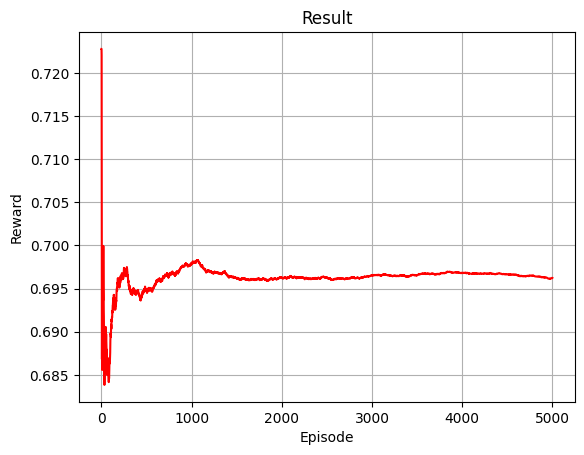

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        shared = self.shared_layer(x)
        policy = self.actor(shared)
        value = self.critic(shared)
        return policy, value

state_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.n

model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=lr) 

def compute_gae(rewards, values, next_value, gamma=0.99, lambda_=0.95):
    values = torch.cat((values, torch.tensor([next_value], dtype=torch.float32)))
    advantages = []
    gae = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lambda_ * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float32)

def ppo(continue_=False):
    if continue_:
        MODEL_PATH = "ppo_no3.pth"
        # load the model
        model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
    
    episode_rewards = []
    for episode in range(episodes):
        state = train_env.reset()[0]
        confusion_matrix = np.zeros((2,2), dtype=int)

        log_probs, values, rewards, states, actions = [], [], [], [], []
        for t in count():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            policy, value = model(state_tensor)
            dist = Categorical(policy)
            action = dist.sample()

            states.append(state_tensor)
            actions.append(action)
            log_probs.append(dist.log_prob(action))
            values.append(value)

            next_state, reward, done, _, info = train_env.step(action.item())
            row_column_index = info["confusion_position"]
            confusion_matrix[row_column_index[0], row_column_index[1]] += 1
            rewards.append(reward)
            state = next_state

            if done:
                next_value = 0 if done else model(torch.tensor(next_state, dtype=torch.float32))[1]
                advantages = compute_gae(rewards, torch.tensor(values), next_value)
                returns = advantages + torch.tensor(values)
                episode_rewards.append(sum(rewards) / (t + 1))
                break

        states = torch.stack(states).detach()
        actions = torch.stack(actions).detach()
        old_log_probs = torch.stack(log_probs).detach()
        values = torch.tensor(values).detach()

        for _ in range(k_epochs):
            policy, value = model(states)
            dist = Categorical(policy)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            actor_loss = - torch.min(surr1, surr2).mean()

            critic_loss = nn.functional.mse_loss(value.squeeze(), returns)

            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        ## graph
        base = confusion_matrix[0, 0] + confusion_matrix[1, 0]
        episode_accuracy.append(
            (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
        )
        episode_precision.append(
            confusion_matrix[0,0] / base if base != 0 else 0
        )
        ##

        if episode % 50 == 0:
            plot_rewards(episode_accuracy)
        
    
    print("Training Complete")
    plot_rewards(episode_accuracy, show_result=True)
    

    train_env.close()
    return episode_rewards

rewards = ppo(continue_=True)

torch.save(model.state_dict(), "ppo_no3.pth")

# plt.figure(figsize=(15, 5))
# plt.plot(rewards)
# plt.show()

In [15]:
torch.save(model.state_dict(), "ppo_no3.pth")

6200 0 0 4728
6264 0 0 4771
6337 0 0 4826
6403 0 0 4873
6457 0 0 4937
6519 0 0 4980
6577 0 0 5031
6645 0 0 5084
6709 0 0 5130


<Figure size 640x480 with 0 Axes>

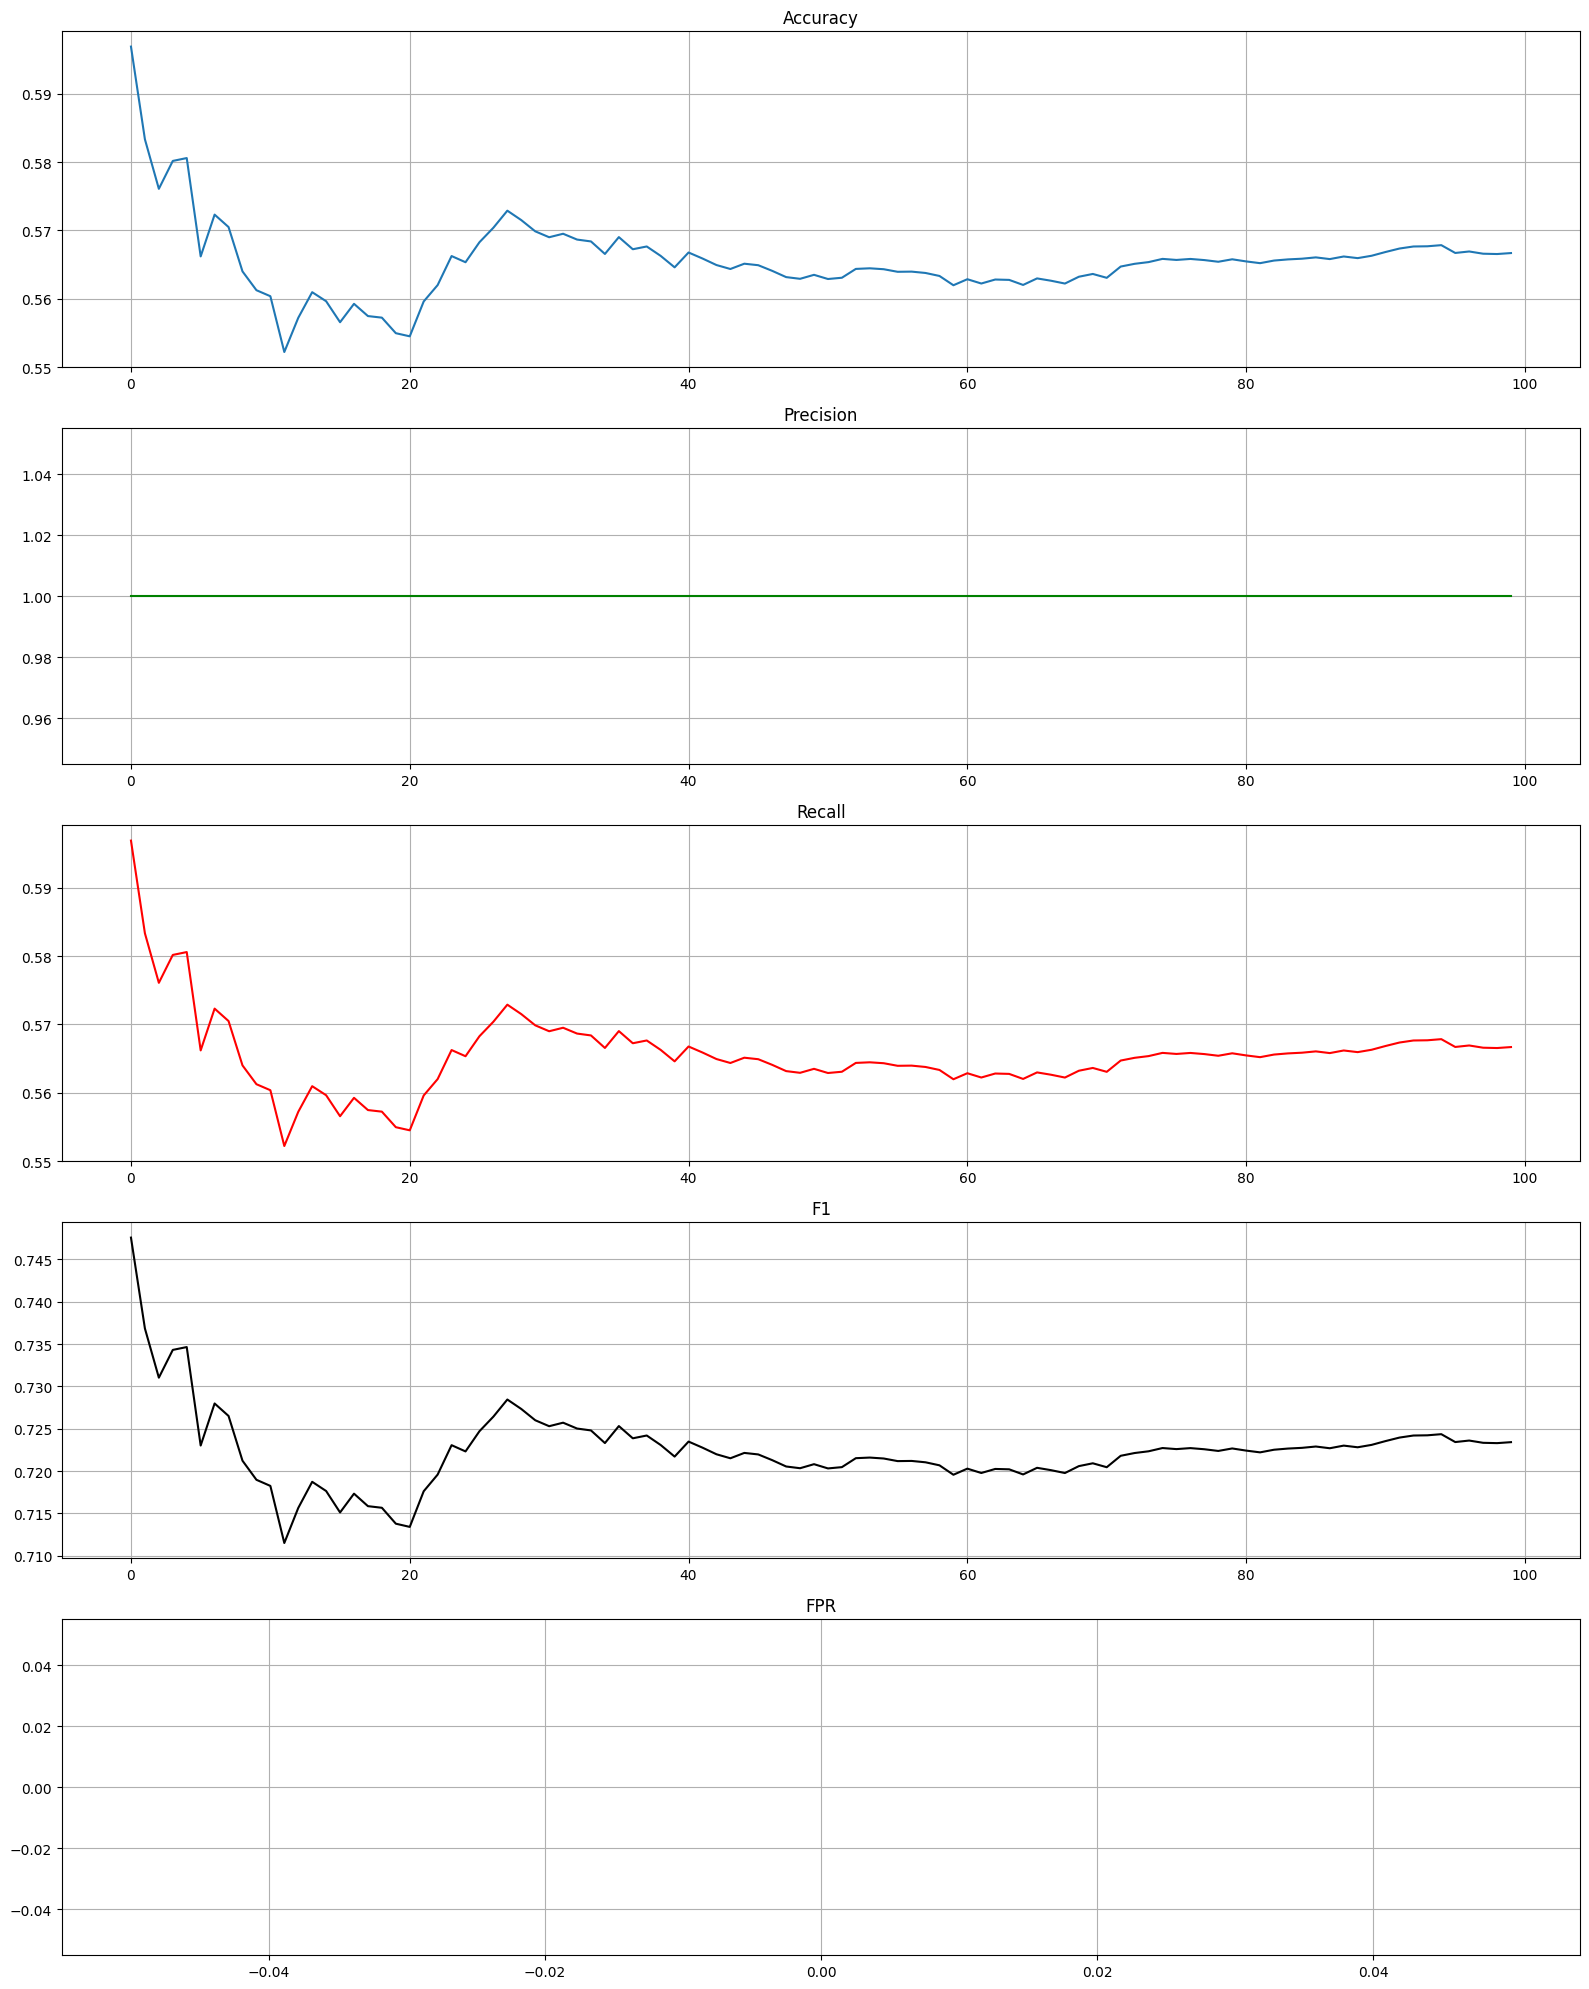

<Figure size 640x480 with 0 Axes>

 accuracy: 0.5666863755384746
precision: 1.0
  recall : 0.5666863755384746
    f1   : 0.7234203148587449
   fpr   : None


<Figure size 640x480 with 0 Axes>

In [16]:
MODEL_PATH = "ppo_no3.pth"

# load the model
trained_network = ActorCritic(state_dim, action_dim)
trained_network.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
trained_network.eval()

# test the model

confusion_array = np.zeros((2, 2), dtype=np.int32)
metrics_dictionary = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

for i_loop in range(100):
    test_raw_state, _ = test_env.reset()
    test_state = torch.tensor(test_raw_state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        with torch.no_grad():
            policy, _ =  trained_network(test_state)
            dist = Categorical(policy)
            test_action = dist.sample()

        test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

        # calculate confusion matrix
        raw = 0 if test_reward == 1 else 1

        # test_info = (row, column) means confusion matrix index
        index = test_info["confusion_position"]
        confusion_array[index[0], index[1]] += 1

        if test_terminated:
            break

        # make next state tensor and update state
        test_state = torch.tensor(test_raw_next_state, dtype=torch.float32).unsqueeze(0)

    # calculate metrics
    tp = confusion_array[0, 0]
    tn = confusion_array[1, 1]
    fp = confusion_array[0, 1]
    fn = confusion_array[1, 0]

    accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
    metrics_dictionary["accuracy"].append(accuracy)
    metrics_dictionary["precision"].append(precision)
    metrics_dictionary["recall"].append(recall)
    metrics_dictionary["f1"].append(f1)
    metrics_dictionary["fpr"].append(fpr)
    print(tp, tn, fp, fn)

    if i_loop % 10 == 0:
        plot_metrics(metrics_dictionary)

# plot metrics
plot_metrics(metrics_dictionary, show_result=True)
print(f" accuracy: {metrics_dictionary['accuracy'][-1]}")
print(f"precision: {metrics_dictionary['precision'][-1]}")
print(f"  recall : {metrics_dictionary['recall'][-1]}")
print(f"    f1   : {metrics_dictionary['f1'][-1]}")
print(f"   fpr   : {metrics_dictionary['fpr'][-1]}")